In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
from copy import deepcopy
import sys
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR, CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir
from neuro.config import repo_dir, PROCESSED_DIR
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
import sasc.viz
from sasc import config
from flatmaps_helper import VOX_COUNTS, load_flatmaps, load_custom_rois, load_known_rois, ROI_EXPLANATIONS_S03

### Load avg-response flatmaps

In [9]:
# main load
normalize_flatmaps = False
gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03, gemv_flatmaps_dict_S02_timecourse, gemv_flatmaps_dict_S03_timecourse = load_flatmaps(
    normalize_flatmaps, load_timecourse=True)

# select
subject = 'S03'
gemv_flatmaps_dict = gemv_flatmaps_dict_S03
gemv_flatmaps_dict = {k: v for k, v in gemv_flatmaps_dict.items(
) if k[0] in ROI_EXPLANATIONS_S03.values() and not k[0] in ['START', 'END']}

### Group regions to analyze into dictionary of voxel indexes
rois_dict is a dictionary with keys as region names and np arrays of voxel masks as values

In [10]:
def load_known_rois(subject):
    nonzero_entries_dict = joblib.load(
        join(regions_idxs_dir, f'rois_{subject}.jbl'))
    rois_dict = {}
    for k, v in nonzero_entries_dict.items():
        mask = np.zeros(VOX_COUNTS[subject])
        mask[v] = 1
        rois_dict[k] = deepcopy(mask)
    if subject == 'S03':
        rois_dict['OPA'] = rois_dict['TOS']
    return rois_dict


rois_dict = load_known_rois(subject)

### Visualize averages over different regions

In [ ]:
ROI_EXPLANATIONS = {
    'EBA': 'Body parts',
    'IPS': 'Descriptive elements of scenes or objects',
    'OFA': 'Conversational transitions',
    'OPA': 'Direction and location descriptions',
    'OPA_only': 'Self-reflection and growth',
    'PPA': 'Scenes and settings',
    'PPA_only': 'Garbage, food, and household items',
    'RSC': 'Travel and location names',
    'RSC_only': 'Location names',
    'sPMv': 'Dialogue and responses',
}
gemv_flatmaps_dict_filt = {
    k[0]: v for k, v in gemv_flatmaps_dict.items() if k[0] in ROI_EXPLANATIONS.values()}
assert len(gemv_flatmaps_dict_filt) == len(ROI_EXPLANATIONS)
rois_dict_filt = {k: v for k, v in rois_dict.items() if k in ROI_EXPLANATIONS}

In [ ]:
gemv_flatmaps_dict_S03_timecourse[('Clothing and Physical Appearance',
                                   None)].shape

In [ ]:
gemv_flatmaps_dict_S03_timecourse[(
    explanation, None)][roi > 0].mean(axis=0).shape

In [46]:
avg_defaultdict = defaultdict(list)
std_defaultdict = defaultdict(list)
num_dict = {}
for roi_idx, roi in rois_dict_filt.items():
    for explanation in gemv_flatmaps_dict_filt.keys():
        avg_defaultdict[roi_idx].append(
            np.mean(gemv_flatmaps_dict_filt[explanation][roi > 0]))
        # corrs_defaultdict[roi_idx].append(
        # np.corrcoef(roi, gemv_flatmaps_dict[explanation])[0, 1])
        roi_timecourse = gemv_flatmaps_dict_S03_timecourse[(
            explanation, None)][roi > 0].mean(axis=0)
        std_defaultdict[roi_idx].append(np.std(roi_timecourse))
        num_dict[explanation] = len(roi_timecourse)

In [ ]:
df = pd.DataFrame(avg_defaultdict, index=gemv_flatmaps_dict_filt.keys())
df_std = pd.DataFrame(std_defaultdict, index=gemv_flatmaps_dict_filt.keys())
df['AVG'] = df.mean(axis=1)
for k in ['RSC', 'PPA', 'OPA']:
    df[k + '_only'] = df[k]

# reindex cols by ROI_EXPLANATIONS keys
df = df[list(ROI_EXPLANATIONS.keys())]

# reindex rows by ROI_EXPLANATIONS values
df = df.reindex(list(ROI_EXPLANATIONS.values()))

# df = df.round(3).sort_values('AVG', ascending=False)
# display pandas formatting with redblue colormap centered at 0 rounded to 3 decimal places
vabs = max(abs(df.values.min()), abs(df.values.max()))

# visualize and outline diagonal elements of matrix
(
    df.style
    .background_gradient(cmap='coolwarm', axis=None, vmax=vabs, vmin=-vabs)
    .format("{:.3f}").set_caption(
        'Average GEM-V driving response averaged over ROI'
    )
)

In [ ]:
s = 'xx-small'
sasc.viz.outline_diagonal(df.shape, color='black', lw=1, block_size=1)
plt.yticks(labels=df.index, ticks=np.arange(df.shape[0]), fontsize=s)
plt.xticks(labels=df.columns, ticks=np.arange(
    df.shape[1]), fontsize=s, rotation=90)

# display as seaborn heatmap
sasc.viz.imshow_diverging(
    df, clab="Mean response ($\sigma$)", clab_size='xx-small')
plt.xlabel('ROI response')
plt.ylabel('Explanation')
plt.show()

In [ ]:
plt.figure(figsize=(7, 3.9))

df_filt = df[['RSC', 'PPA', 'OPA']]
XLABS = ['RSC', 'PPA', 'OPA',  'RSC_only', 'PPA_only', 'OPA_only']
df_filt = df_filt.loc[[ROI_EXPLANATIONS[k] for k in XLABS]]
df_filt = df_filt.T

s = 'medium'
dvu.outline_diagonal(df_filt.shape, color='black',
                     lw=1, block_size=1, roffset=0)
dvu.outline_diagonal(df_filt.shape, color='black',
                     lw=1, block_size=1, roffset=3)
# sasc.viz.outline_diagonal(df_filt.shape, color='black', lw=1, block_size=1)
plt.yticks(labels=df_filt.index, ticks=np.arange(df_filt.shape[0]), fontsize=s)
plt.xticks(labels=[x.replace('_', '-') for x in XLABS], ticks=np.arange(
    df_filt.shape[1]), fontsize=s, rotation=45)

# display as seaborn heatmap
sasc.viz.imshow_diverging(
    df_filt, clab="Mean response ($\sigma$)", clab_size='large')
plt.xlabel('Driving paragraph', fontsize='large')
plt.ylabel('ROI response', fontsize='large')
plt.savefig(join(config.RESULTS_DIR, 'figs/main',
            'S03' + '_roi_heatmap.pdf'), bbox_inches='tight')
plt.show()

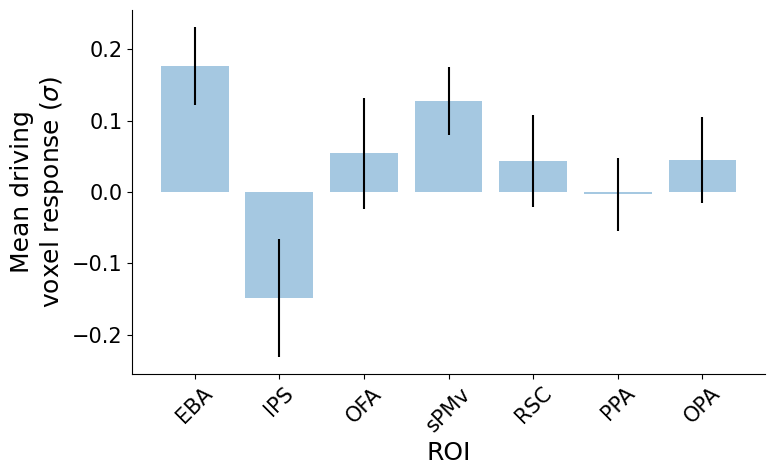

In [69]:
# plot diagonal as barplot
plt.figure(figsize=(8, 5))
XLABS = ['EBA', 'IPS', 'OFA', 'sPMv', 'RSC', 'PPA', 'OPA']
df_bar = df[XLABS]
df_bar = df_bar.loc[[ROI_EXPLANATIONS[k] for k in XLABS]]
mat = df_bar.values

# normalize mat rows
# mat = (mat - np.nanmean(mat, axis=1)[:, None]) / np.nanstd(mat, axis=1)[:, None]
n = len(mat)
vals_diag = mat.diagonal()
vals_off_diag = np.nanmean(mat, axis=1)
vals = vals_diag * (1 + 1/n) - vals_off_diag

stds = df_std[XLABS].loc[[ROI_EXPLANATIONS[k] for k in XLABS]]
stderrs = [stds.values.diagonal()[i] / np.sqrt(num_dict[ROI_EXPLANATIONS[XLABS[i]]])
           for i in range(len(XLABS))]

# make errorbars gray
plt.bar(range(len(vals)), vals, color='C0', alpha=0.4, yerr=stderrs)
# add xlabel
plt.xticks(range(len(vals)), df_bar.columns, rotation=45)
plt.xlabel('ROI', fontsize='large')
plt.ylabel('Mean driving\nvoxel response ($\sigma$)', fontsize='large')
plt.tight_layout()
plt.savefig(join(config.RESULTS_DIR, 'figs/main',
            'S03' + '_roi_barplot.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
# sasc.viz._save_flatmap(
#     gemv_flatmaps_dict[('relationships between people', 'qa')], subject, fname_save=f'gemv_flatmaps/relationships_{subject}.png')